## Model Overview

A generative model (𝐺) is pitted against an adversary: a
discriminative (𝐷) model that learns to determine whether a sample is from the generative model distribution or the data distribution.

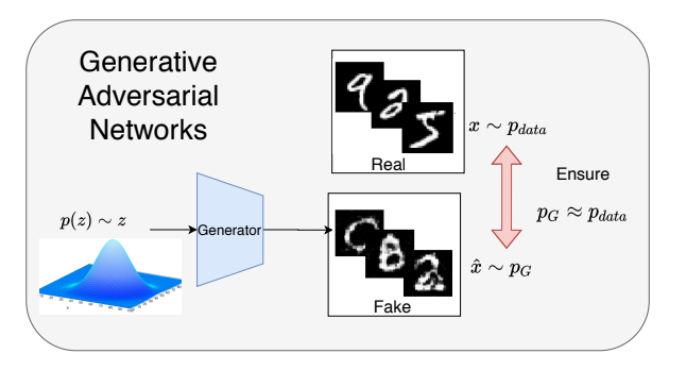

*   Introduce latent variable z with simple prior $p(𝑧)$ (e.g. Gaussian)
*   Sample $z ∼ p(𝑧)$, pass it through Generator $\hat{x} = G(z)$; where $\hat{x} ∼ p_G$
*   Introduce mechanism to ensure $p_G ≈ p_{data}$


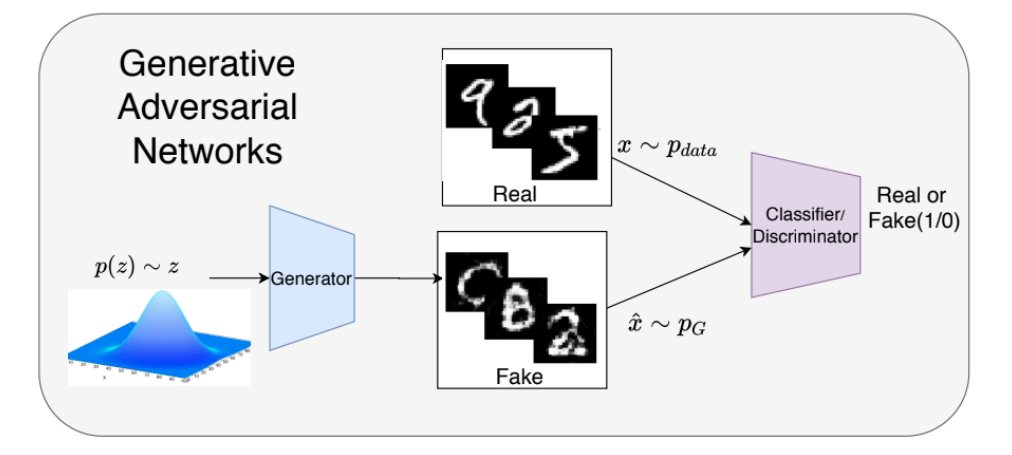

* Use a classifier (called discriminator) that differentiates between real samples $x ∼ p_{data} (class 1)$ and $\hat{x} ∼ p_{G} (class 0)$
* Train generator G such that discriminator misclassifies generated sample \hat{x} into class 1
=⇒ can no more differentiate between $x ∼ p_{data}$ and $\hat{x} ∼ p_{G}$

In [ ]:
# Import Libraries
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set for testing purposes, please do not change!
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


The below function is for visualizing images: Given a tensor of images, number of images, and size per image, plots and prints the images in a uniform grid.

In [ ]:
"""
:param image_tensor: PyTorch tensor containing flattenned image data
:param num_images: number of images to display from the tensor
:param size: images are flattened so we need to unflatten them back to original MNIST size
"""
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size) #disconnect tensor from computational graph and reshape
    image_grid = make_grid(image_unflat[:num_images], nrow=5) #select num images from image_unflat and organize images into a grid (nro)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze()) #rearranges the dimensions of the image grid from (C,H,W) to (H,W,C) which is required by matplotlib for display
    plt.show()

## Generator Architecture

This function creates a single block for generator network given input_dim and output_dim

This block contains
1. Linear transformation to map to another shape,
  * in_features=input_dim
  * out_features=output_dim
2. Batch Normalization
  * num_features : output_dim
3. Activation Function (Relu)
  * inplace : True
  
  
Returns a generator neural network layer, with a linear transformation followed by a batch normalization and then a relu activation. We will be using this blocks to create a generator

In [ ]:
'''
A modular unit that combines a series of layers and operations to perform a specific transformation on the input data. 
In a generator, these blocks are designed to progressively refine and reshape a simple input (often random noise) into 
a structured, meaningful output.

:param input_dim: The dimensionality of the input vector to this block
:param output_dim: The dimensionality of the output vector produced by this block
'''

def get_generator_block(input_dim, output_dim):

    return nn.Sequential( #container for stacking multiple layers in order
        nn.Linear(in_features=input_dim, out_features=output_dim), #fully connected layer that applies linear transformation
        nn.BatchNorm1d(num_features=output_dim), #normalizes the output from the linear layer
        nn.ReLU(inplace=True) #ReLU activation for non-linearity
    )

Below we implement a Generator Class

* Architecture of the Generator looks like this :

  z_dim : the dimension of the noise vector =10
  
  im_dim: dimension of the flattened images=784,
  
  hidden_dim=128
  * Generator block( 10 , 128)
  * Generator block( 128 , 128*2)
  * Generator block( 128 * 2 , 128 * 4)
  * Generator block( 128 * 4 , 128 * 8)
  * Linear layer
    * what should be the dimensions of the linear layer ?
  * Sigmoid Activation

A function for completing a forward pass of the generator. Given a noise tensor, returns generated images.





In [ ]:
class Generator(nn.Module):
    '''
    :param z_dim: The dimensionality of the random noise vector 
    :im_dim: The dimensionality of the generated image  
    :hidden_dim: The dimensionality of the hidden layers 
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        '''
        The generator network is built using nn.Sequential, which stacks layers in order. 
        How it works 
            1 - Noise Input: The generator takes a random noise vector 𝑧 z of dimension z_dim. 
            2 - Hidden Layers: The get_generator_block function is used to create 4 layers, expanding dimensions (128->256->512->1024​  
                 Each block includes a linear transformation, batch normalization, and a ReLU activation function. 
            3 - Final Transformation: The final nn.Linear layer maps the last hidden layer to the output dimension im_dim (784 for MNIST). 
            4 - Output Activation: nn.Sigmoid() outputs values in the range [0,1], suitable for image pixels (grayscale).
        '''
       
        self.gen = nn.Sequential(

            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),


            # Final Layer containing Linear transformation with in_features from previous layer and out_features as im_dim
            #Generator architecture
            nn.Linear(in_features=(hidden_dim * 8), out_features=im_dim),
            # Sigmoid Activation Function
            nn.Sigmoid()

        )
    '''
    :param noise: A batch of random noise vectors of shape (batch_size, z_dim)
    '''
    def forward(self, noise):
        return self.gen(noise) #passes the noise through the generator network

    def get_gen(self):
        return self.gen #returns the generator network

## Noise

To train generator, we need to create noise vectors.

This function generates noise vector by sampling random numbers from the normal distribution given
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type

In [ ]:
'''
:param n_samples: number of noise vectors (or samples) to generate where each noise vector corresponds to one input to the generator
:param z_dim: dimensionality of each noise vector, represents the size of the latent space
:param device: device used (GPU for CPU)
'''
def get_noise(n_samples, z_dim, device='cpu'):
    #generates a tensor of shape (n_samples,z_dim) 
    #each element is drawn from a standard normal distribution
    return torch.randn(n_samples,z_dim,device=device)

## Discriminator Architecture

This function creates a single block for Discriminator network given input parameters

input_dim: the dimension of the input vector, a scalar

output_dim: the dimension of the output vector, a scalar

This block contains
1. Linear transformation to map to another shape,
  * in_features=input_dim, out_features=output_dim
2. Activation Function (Relu)
  * negative_slope = 0.2 , inplace =True

It returns a neural network block of the discriminator. We are going to stack many number of blocks to create Discriminator Architecture.

In [ ]:
'''
input_dim: dimensionality of the input data to the block 
output_dim: dimensionality of the output data after the block
'''

def get_discriminator_block(input_dim, output_dim):

    return nn.Sequential(
        nn.Linear(in_features=input_dim, out_features=output_dim), #projects the input data into a lower-dimensional space, which helps the discriminator focus on progressively refined features

        nn.LeakyReLU(negative_slope=0.2,inplace=True) #introducses non-linearity
    )

In the Discriminator class we will build a network with 4 layers. Start with the image tensor and perform the transformation until it returns a single number (i.e. 1-dimensional tensor output)

Each intermediate layer in the network will have hidden_dim

Architecture of the Discriminator is as given below :

im_dim: the dimension of the flattened images, fitted for the dataset used, a scalar (MNIST images are 28x28 = 784 so that is your default)

hidden_dim: the inner dimension, a scalar

* Discriminator block( 784 , 128 * 4)
* Discriminator block( 128 * 4 , 128 * 2)
* Discriminator block( 128 * 2 , 128)
* Linear layer
  * what should be the dimensions of the linear layer ?

This has only linear transformation with in_features: hidden_dim and out_features: 1

In [ ]:
#discriminator's job is to classify input data (e.g., images) as real (from the dataset) or fake (generated by the generator)
class Discriminator(nn.Module):
    '''
    :param im_dim: dimensionality of the input images, flattened into vectors 
    :param hidden_dim: size of  hidden layer 
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        
        super(Discriminator, self).__init__()
        '''
        Each hidden layer contains fully connected layer to reduce dimensionality and leaky ReLU to introduce non-linearity
        Progressively reduce dimensionality of input so "important" features are extracted
        '''
        self.disc = nn.Sequential(

            get_discriminator_block(im_dim, hidden_dim * 4),

            # Layer-2
            get_discriminator_block(hidden_dim * 4,hidden_dim*2),

            # Layer-3
            get_discriminator_block(hidden_dim*2, hidden_dim),

            #Discriminator architecture
            nn.Linear(in_features=hidden_dim, out_features=1) #final dim is 1 (fake or real)

        )

    def forward(self, image):
        return self.disc(image)

    def get_disc(self):
        return self.disc

## Loading data

In [ ]:

batch_size = 128

# Check availability of GPU and set the device accordingly
device = 'cuda'

# The following block is to mitigate the temporary issue within PyTorch about downloading MNIST. Don't change!
"""new_mirror = 'https://ossci-datasets.s3.amazonaws.com/mnist'
MNIST.resources = [
   ('/'.join([new_mirror, url.split('/')[-1]]), md5)
   for url, md5 in MNIST.resources
]"""
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.21MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
z_dim = 64
# create a generator
gen = Generator(z_dim).to(device)

# create a discriminator
disc = Discriminator().to(device)


$$
\text { Training Objective: } \min _{G} \max _{D}\left(\mathbb{E}_{x \sim p_{\text {data }}}[\log D(x)]+\mathbb{E}_{z \sim p_{z}}[\log (1-D(G(z))])\right.
$$

$$
O_{1}=\max _{D} \mathbb{E}_{x \sim p_{\text {data }}}[\log D(x)]
$$
Train discriminator, $D$, such that if sample belongs to $p_{\text {data }}$, maximize the log probability of it being a real sample

$$
O_{2}=\min _{G} \mathbb{E}_{z \sim p_{z}}[\log (1-D(G(z))]
$$
Train Generator, $G$ such that if sample belongs to $p_{G}($ i.e $G(z))$, maximize the log probability of it being a real sample

* for number of training iterations do

  * for $k$ steps do
    - Sample minibatch of $m$ noise samples from noise prior $p_{g}(\boldsymbol{z})$.
    - Sample minibatch of $m$ examples from data generating distribution $p_{\text {data }}(\boldsymbol{x}) .$
    - Update the discriminator by ascending its stochastic gradient:
$$
\nabla_{\theta_{d}} \frac{1}{m} \sum_{i=1}^{m}\left[\log D\left(\boldsymbol{x}^{(i)}\right)+\log \left(1-D\left(G\left(\boldsymbol{z}^{(i)}\right)\right)\right)\right]
$$
  * end for
  - Sample minibatch of $m$ noise samples $\left\{\boldsymbol{z}^{(1)}, \ldots, \boldsymbol{z}^{(m)}\right\}$ from noise prior $p_{g}(\boldsymbol{z})$.
  - Update the generator by descending its stochastic gradient:
$$
\nabla_{\theta_{g}} \frac{1}{m} \sum_{i=1}^{m} \log \left(1-D\left(G\left(\boldsymbol{z}^{(i)}\right)\right)\right)
$$
* end for

The gradient-based updates can use any standard gradient-based learning rule. We used momentum in our experiments.

## Discriminator loss function
This function returns the loss of the discriminator given inputs.

  * gen: the generator model, which returns an image given z-dimensional noise

  * disc: the discriminator model, which returns a single-dimensional prediction of real/fake

  * criterion: the loss function, which should be used to compare the discriminator's predictions to the ground truth reality of the images (e.g. fake = 0, real = 1)

  * real: a batch of real images
  * num_images: the number of images the generator should produce, which is also the length of the real images

  * z_dim: the dimension of the noise vector, a scalar
  * device: the device type


Create noise vectors, use existing defined get_noise function to create noise. Pass this noise vectors as input to generate batch (num_images) of fake images using gen defined above.

These generated fake images are passed to discriminator for prediction  using disc defined above. Make sure to use .detach() on generator results i.e. fake.detach() since generator is needed to calculate discriminator loss.
This ensures that only the discriminator is updated

Calculate loss using criterion defined earlier.Ground truth for fake images are all zeros

Pass the batch of real images to discriminator for predictions using disc defined above

Calculate loss using criterion defined earlier. Ground truth for real images are all ones

Take avg of disc_fake_loss and disc_real_loss and return the average discriminator loss

In [ ]:
'''
Generates fake images using a generator model 
:param gen: generator model, expected to transform random noise into structured data
:param num_images: number of fake images to generate
:param z_dim: size of the random noise vector that is input to the generator
'''
def gen_fake(gen, num_images, z_dim, device):
  fake_noise = get_noise(num_images, z_dim, device="cuda")
  fake = gen(fake_noise)
  return fake

In [ ]:
'''
Function calculates the discriminator's loss during training. The discriminator's job is to correctly classify real samples as real and 
fake samples as fake.
:param gen: generator model, which creates fake samples to try and fool discriminator
:param disc: discriminator model, which tries to distinguish between real and fake data
:param criterion: loss function 
:param real: batch of real samples from dataset 
:param num_images: number of samples
:param z_dim: dimensionality of the random noise vector used by the generator to create fake samples
'''

def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    fake = gen_fake(gen, num_images, z_dim, device) #calls the generator to create a batch of fake data using random noise.
    disc_fake_pred = disc(fake.detach()) #pass fake samples to disc, detach to prevent gradients flowing back to gen as we are only training disc
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) #computes loss between  disc predictions (disc_fake_pred)
                                                                                 #and ground truth labels (torch.zeros_like(disc_fake_pred)
                                                                                 #zeros like b/c 0 is fake and these are fake samples
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred)) #same logic as above 
    disc_loss = (disc_fake_loss + disc_real_loss) / 2 #average the two

    return disc_loss


## Generator Loss function

This function gives loss of the Generator given inputs
* gen: the generator model, which returns an image given z-dimensional noise
* disc: the discriminator model, which returns a single-dimensional prediction of real/fake
* criterion: the loss function, which should be used to compare the discriminator's predictions to the ground truth reality of the images (e.g. fake = 0, real = 1)
* num_images: the number of images the generator should produce, which is also the length of the real images
* z_dim: the dimension of the noise vector, a scalar
* device: the device type



Create noise vectors, use existing defined get_noise function to create noise, ensure use of device argument.

Pass this nosie vectors to generate a batch (num_images) of fake images by using gen defined above.

Also collect Discriminator predictions on the above generated fake images using disc defined earlier

Calculate generator loss using criterion.For Ground truth remember that generator wants discriminator to think that fake images are real

In [ ]:
'''
Calculates the generator's loss during training. The generator's job is to produce fake samples that are realistic enough to fool the 
discriminator into classifying them as real.
:param gen: generator model
:param disc: discriminator model
:param criterion: loss function
:param num_images: number of samples
:param z_dim: dimensionality of the random noise vector used by the generator to create fake samples
'''

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):

    fake = gen_fake(gen, num_images, z_dim, device) #generate fake samples
    disc_fake_pred = disc(fake) #classify as fake or real using discriminator
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred)) #generator wants the discriminator to classify all fake samples 
                                                                          #as real (1) hence torch.ones_like
    return gen_loss

## Show Image

In [ ]:
def show_image():
    from torchvision.utils import make_grid
    fake_noise = torch.rand(128,z_dim,device=device)
    fake = gen(fake_noise)
    unflattened_image = fake.detach().cpu().view(-1, *(1, 28, 28))
    loss = get_gen_loss(gen, disc, criterion, 128, z_dim, device)
    image_grid = make_grid(unflattened_image[:25], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Training

In [ ]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
display_step = 500
lr = 0.00001

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)


cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):

    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        real = real.view(cur_batch_size, -1).to(device)

        disc_opt.zero_grad()

        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        disc_loss.backward(retain_graph=True)

        disc_opt.step()

        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        # Zero out the gradients
        gen_opt.zero_grad()
        # Calculate generator loss, use existing function get_gen_loss defined for loss calculation
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        # Backprop through the generator: update the gradients
        gen_loss.backward(retain_graph=True)
        # update optimizer
        gen_opt.step()

        if test_generator: # For testing purposes, to check that your code changes the generator weights
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        mean_discriminator_loss += disc_loss.item() / display_step

        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0: ### Visualization code ###
            print(f"Epoch {epoch} Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            image_unflat = fake.detach().cpu().view(-1, *(1, 28, 28))
            image_grid = make_grid(image_unflat[:25], nrow=5)
            save_image(image_grid, "training_image.png")
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
    if epoch % 50 == 0:
        show_image()
